Maybe we can pick our favorite companies from a few different industries, do some API looping to gather data on all of them, create a dataframe out of it, do groupings to separate them out into Big vs Small, Industry, any way we wanna splice it. From there we can do aggregations and visuals to show how each company has done over a certain timeframe, find out if COVID has affected any industry the most, big or small companies, do some linear regression for actual correlation from March - forward. Lots to do, simple project stuff, would make life easy with how much documentation there is

In [1]:
# Dependencies
!pip install yfinance
import requests
import json
import pandas as pd
import yfinance as yf
import datetime as dt
from pprint import pprint
import matplotlib.pyplot as plt

# Google developer API key
from api_key import api_key

### Pull Financial Data

Focus on stores selling general merchandise

In [2]:
tickers = ['KSS','TGT','M','DG','DLTR']

1. For these 5 selected companies, use API to retrieve financial data per quarter
2. For each quarter, save some key data points
3. Save the data into a dataframe, quarterly_data

In [3]:

url = "https://financialmodelingprep.com/api/v3/income-statement/"
quarterly_data = pd.DataFrame()
for ticker in tickers:
    query_url = f"{url}{ticker}?period=quarter&apikey={api_key}&limit=5"
    ticker_response = requests.get(query_url)
    ticker_json = ticker_response.json()
    
    #loop thru the quarters for each company
    for quarter in ticker_json:
     #revenue, cost of revenue, ticker price 
        quarterly_nums = pd.Series({"sym":ticker, 
                                    "date":quarter['date'],
                                    "revenue":quarter['revenue'],
                                    "costOfRevenue":quarter['costOfRevenue'],
                                    "operatingExpenses":quarter['operatingExpenses']
                                   })
        quarterly_data = quarterly_data.append(quarterly_nums,ignore_index=True)
quarterly_data.sort_values(by=["sym","date"],ascending=True,inplace=True)
quarterly_data.head()

,costOfRevenue,date,operatingExpenses,revenue,sym
19,4.926307e+09,2019-11-01,1.573669e+09,6.991393e+09,DG
18,4.884879e+09,2020-01-31,1.551888e+09,7.157642e+09,DG
17,5.852757e+09,2020-05-01,1.728908e+09,8.448449e+09,DG
16,5.866006e+09,2020-07-31,1.775608e+09,8.684241e+09,DG
15,5.631385e+09,2020-10-30,1.795110e+09,8.199625e+09,DG


### Plot the data points for each company 
This gives a general sense of the data collected

   costOfRevenue        date  operatingExpenses       revenue  sym
4   2.775000e+09  2019-11-02       1.637000e+09  4.625000e+09  KSS
3   4.400000e+09  2020-02-01       2.031000e+09  6.832000e+09  KSS
2   1.600000e+09  2020-05-02       1.546000e+09  2.428000e+09  KSS
1   2.149000e+09  2020-08-01       1.140000e+09  3.407000e+09  KSS
0   2.424000e+09  2020-10-31       1.302000e+09  3.979000e+09  KSS
   costOfRevenue        date  operatingExpenses       revenue  sym
9   1.293500e+10  2019-11-02       4.728000e+09  1.866500e+10  TGT
8   1.705600e+10  2020-02-01       5.145000e+09  2.339900e+10  TGT
7   1.451000e+10  2020-05-02       4.637000e+09  1.961500e+10  TGT
6   1.567300e+10  2020-08-01       5.002000e+09  2.297500e+10  TGT
5   9.630000e+08  2020-10-31       5.870000e+08  3.017000e+09  TGT
    costOfRevenue        date  operatingExpenses       revenue sym
14   3.106000e+09  2019-11-02       2.210000e+09  5.356000e+09   M
13   5.266000e+09  2020-02-01       2.828000e+09  8.577000e+09

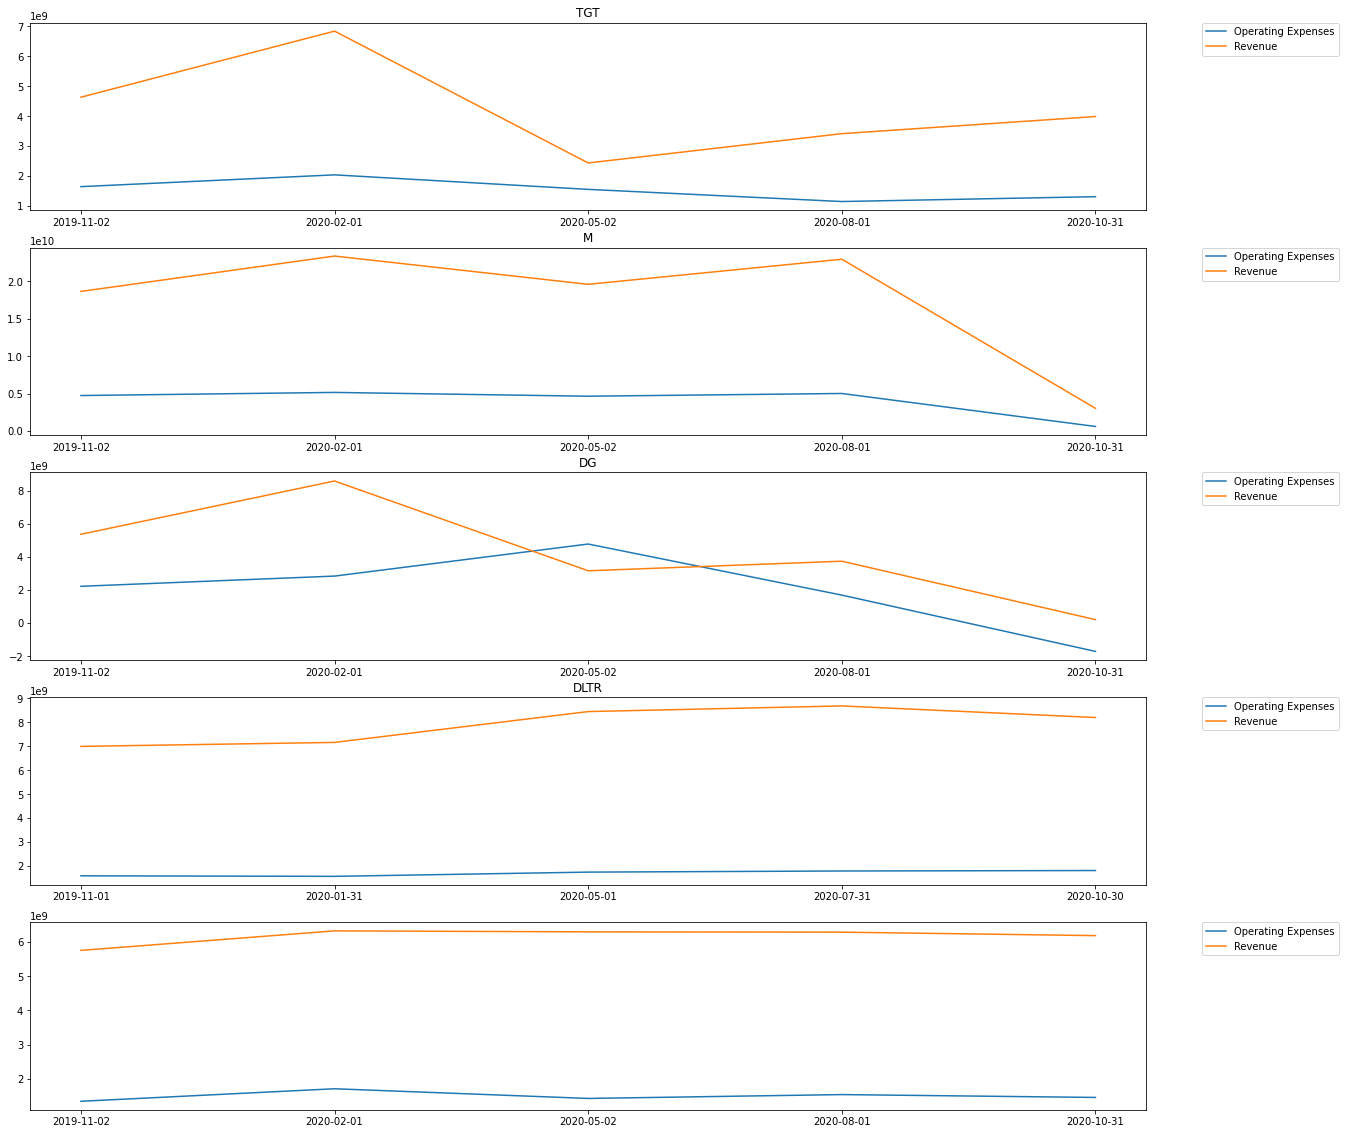

In [13]:
retailer_groups = quarterly_data.groupby("sym")

for name,group in retailer_groups:
    group.sort_values(by="date",ascending=True)
    #axis1 = group["date"]
    #yaxis = group["revenue"]
    #plt.plot(xaxis,yaxis)
    #group.plot.line(title=name)
    outputFile = "Output/" + name + "_QtrFinancials.csv"
    group.to_csv(outputFile)
    
fig= plt.figure(figsize=(20,20))
i=1
for ticker in tickers:
    ticker_group= quarterly_data.loc[quarterly_data["sym"] == ticker]
    print(ticker_group)
    xaxis = ticker_group["date"]
    yaxis_rev = ticker_group["revenue"]
    yaxis_exp = ticker_group["operatingExpenses"]
    plt.title('{}'.format(ticker))
    plt.subplot(5,1,i)
    plt.plot(xaxis,yaxis_exp,label = "Operating Expenses")
    plt.plot(xaxis,yaxis_rev,label = "Revenue")
    i = i+1
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show

plt.savefig("Output/Rev_and_Expense.png")   

### Collect historical stock price data for each company using yfinance

In [ ]:
openPrices = pd.DataFrame()
for ticker in tickers:

    ticker_prices = yf.Ticker(ticker)
    tickerHistory= ticker_prices.history(period = "24mo")
    tickerHistory= tickerHistory.reset_index()
    outputFile = "Output/" + ticker + "_StockHistory.csv"
    tickerHistory.to_csv(outputFile)
    singletickerData = quarterly_data.loc[quarterly_data["sym"]== ticker]

    for index, row in singletickerData.iterrows():
        stockPriceRow = pd.DataFrame()
        currDate_str = row['date']
        while (stockPriceRow.empty):
            currDate_dt = dt.datetime.strptime(currDate_str,'%Y-%m-%d')
            stockPriceRow = tickerHistory.loc[tickerHistory["Date"]==currDate_str]
            if (stockPriceRow.empty):
                prevDate_dt = currDate_dt + dt.timedelta(days=1)
                currDate_str =  prevDate_dt.strftime('%Y-%m-%d')
            else:
                #stockPriceRow.loc["sym"] = ticker
                openPrices = openPrices.append(stockPriceRow, ignore_index = True)

openPrices.head()
            
                          



    



    



### Combine data from Financial api and ticker data

In [ ]:
quarterly_data['Open'] = openPrices['Open']
quarterly_data

In [ ]:
quarterly_data["OpenDate"] = openPrices["Date"]

In [ ]:
quarterly_data.to_csv("Output/AllQuarterlyData.csv")

### plot stock trends

In [ ]:
retailer_groups = quarterly_data.groupby("sym")

def plot_graph(ticker,name):
    #make an iternal copy and sort it, to get in correct order without warnings
    tickerList = ticker.copy(deep=True)
    tickerList.sort_values(by=['OpenDate'],ascending=True, inplace=True)
    xaxis = tickerList['OpenDate']
    yaxis = tickerList['Open']
    plt.plot(xaxis,yaxis)

    plt.xlabel('Date')
    plt.ylabel(f'Stock Price $')
    plt.title(f'Stock Price Over Quarters')
    prev_y = 0
    print(name)
    for x,y in zip(xaxis,yaxis): 
        if (prev_y == 0):
            prev_y = y
            continue
        change = str(round(((y / prev_y) - 1) * 100,1)) + '%'
        print (f" Qtr: {round(prev_y,1)} >> {round(y,1)} ({change})")
        plt.annotate(text =change,xy = (x,y),xytext = (x,(y + 2)))
        prev_y = y

tickerNames = []
for name,group in retailer_groups:
    plot_graph(group,name)
    tickerNames.append(name)

plt.legend(tickerNames)
plt.savefig("Output/Qtr_Stock_Open.png")  